# CSI #

The problem we are interested in solving is determining *causal* relationships within a timeseries dataset.  By causal, we mean that we can reduce variance in the estimate of a gene $i$ at any given timepoint given a gene (or set of genes—termed the *parental set* $P_{i,j}$ of the gene) at the previous time point.  The parental set is drawn from the powerset of the genes included in the data and truncated at some depth (i.e. maximum number of parents) in order to stop the model getting too "big".

## Model Definition ##

We define $\theta_i$ as the hyperparamaters associated with the gene $i$, and $\Sigma(X,\theta)$ the multivariate-normal covariance given by the squared-exponential kernel.  The probability of the expression data for the gene given parental set $S_{i,j}$ is therefore:

  $ P(X_i \mid X'_{S_{i,j}}, \theta_i) = \textbf{N}(X_i, \Sigma(X'_{S_{i,j}}, \theta_i)) $

Because we are interested in discovering causal relationships, we want to know which parental sets best explain our gene of interest.  We therefore want to weight the parental sets by their explanatory power, so we introduce $w_{i,j}$, constrained such that $\forall i \sum_j w_{i,j} = 1$.

1. Ask Chris why we don't give a non-uniform prior? so that EM reweighting can be easier?

The likelihood of our gene given the parental sets and associated weights is therefore:

  $ P(X_i \mid \theta_i, w_i) \propto \prod_j P(X_i \mid X'_{S_{i,j}}, \theta_i) ^ {w_{i,j}} $

We can perform expectation-maximisation of the above above model by interleaving minimisations of $\theta_i$ and reweightings of $w_i$.  We define model convergence as the KL divergence of the reweight step going below $10^{-5}$.

## Interpretation ##

The weight of each parental set are of most interest to biologists, and are interpreted as the probability of the parental set as having casual influence on the gene of interest.  The argument for causality is left as an exercise for the reader!

We are left with a high dimensional space that we need to visualise in order to gain much understanding.  One metaphor that users are accustomed to are network diagrams that specify which genes are influencing each other.

In [2]:
%matplotlib inline
%load_ext autoreload

%autoreload 2

In [4]:
import itertools as it

import numpy as np
import scipy as sp
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import GPy

import csi

Read in data, then convert the second level (i.e. index=1) from strings to floats.  This conversion ensures that columns are recognised as "sorted" and `.loc` slicing works as expected.

In [5]:
inp = pd.read_csv("csi/testdata/Demo_DREAM.csv",index_col=0,header=[0,1])

inp.columns = pd.MultiIndex.from_tuples([(a,float(b)) for a,b in inp.columns],
                                        names=inp.columns.names)

In [6]:
inp.loc["Gene1",("T1",pd.IndexSlice[0:500])]

Treatment  Time
T1         0       0.709247
           50      0.227989
           100     0.080199
           150     0.007677
           200     0.004652
           250     0.003049
           300     0.000790
           350     0.000000
           400     0.002035
           450     0.002429
           500     0.005413
Name: Gene1, dtype: float64

I define `inpX` to be the inputs to the GP regressions and `inpY` the outputs.  Given time series upto $t$, `inpX` therefore contains indicies $1\dots t-1$ and `inpY` indicies $2\dots t$, i.e. both contain one less element than `inp`.

This is all somewhat complicated by the fact that we have replicates, I currently don't want to assume that every replicate has the same number of time points.  However, given the requirement that the time points are "evenly" spaced kind of implies that each replicate will always have exactly the same time points associated.

In [7]:
def getIndicies(x):
    """Returns indicies, [i], where item $x_i = x_{i-1}$."""
    prev = None
    for i, a in enumerate(x):
        if a == prev:
            yield i
        prev = a

ix = np.array(list(getIndicies([a for a,b in iter(inp.columns)])))
inpX = inp.iloc[slice(None),ix-1].T
inpY = inp.iloc[slice(None),ix].T

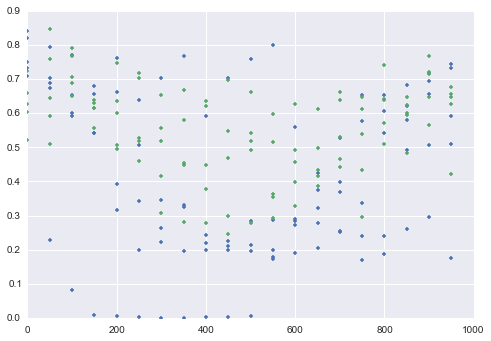

In [8]:
plt.plot([b for a,b in inpX.index],
         inpX[["Gene1","Gene2"]],'.');

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,0.172819304254,+ve,,
rbf.lengthscale,0.248134803077,+ve,,
Gaussian_noise.variance,0.0295289601331,+ve,,


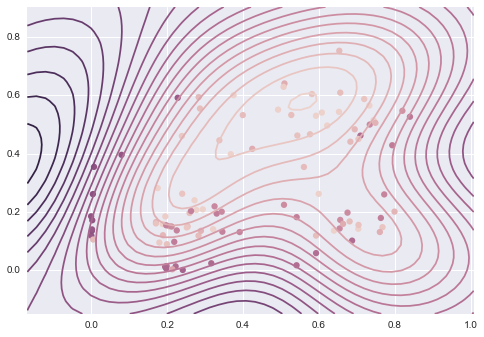

In [9]:
m = GPy.models.GPRegression(inpX[["Gene1","Gene8"]],inpY[["Gene10"]])
m.optimize()
m.plot(cmap=sns.cubehelix_palette(reverse=True, as_cmap=True));
m

In [10]:
cc = csi.Csi(inp)
em = cc.getEm()
em.setup(cc.allParents("Gene2",3))

KL Div: 1.69335e-07, hypers: [ 0.19761286  1.40609978  0.00552952]
CPU times: user 1.15 s, sys: 75.9 ms, total: 1.22 s
Wall time: 1.18 s


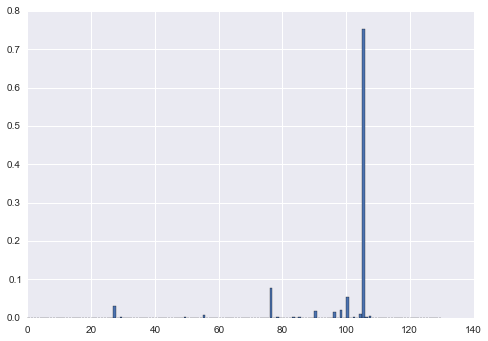

In [15]:
%%time
res = em.optimiseHypers()
print("KL Div: %g, hypers: %s" % (em.reweight(),str(em.hypers)))
plt.bar(range(len(em.weights)),em.weights)

105: 108.09 = Gene4,Gene7,Gene9
 76: 105.81 = Gene3,Gene4,Gene7
100: 105.46 = Gene4,Gene6,Gene7
 27: 104.87 = Gene4,Gene7
 98: 104.49 = Gene4,Gene5,Gene9
 90: 104.31 = Gene3,Gene7,Gene9
 96: 104.14 = Gene4,Gene5,Gene7
104: 103.62 = Gene4,Gene7,Gene8
 55: 103.38 = Gene1,Gene4,Gene7
107: 102.99 = Gene4,Gene8,Gene9
 78: 102.49 = Gene3,Gene4,Gene9
 83: 102.48 = Gene3,Gene5,Gene9
106: 102.06 = Gene4,Gene7,Gene10
 85: 101.91 = Gene3,Gene6,Gene7
 29: 101.68 = Gene4,Gene9
102: 101.62 = Gene4,Gene6,Gene9
 49: 101.38 = Gene1,Gene3,Gene7
 21: 101.09 = Gene3,Gene7
 91: 101.08 = Gene3,Gene7,Gene10
 75: 100.49 = Gene3,Gene4,Gene6
 87:  99.97 = Gene3,Gene6,Gene9
 81:  99.75 = Gene3,Gene5,Gene7
 97:  99.37 = Gene4,Gene5,Gene8
 89:  99.28 = Gene3,Gene7,Gene8
 74:  98.98 = Gene3,Gene4,Gene5
109:  98.86 = Gene4,Gene9,Gene10
 57:  98.72 = Gene1,Gene4,Gene9
 77:  98.17 = Gene3,Gene4,Gene8
 95:  98.00 = Gene4,Gene5,Gene6
 48:  97.83 = Gene1,Gene3,Gene6
101:  97.79 = Gene4,Gene6,Gene8
 28:  97.71 = Gene4,Gen

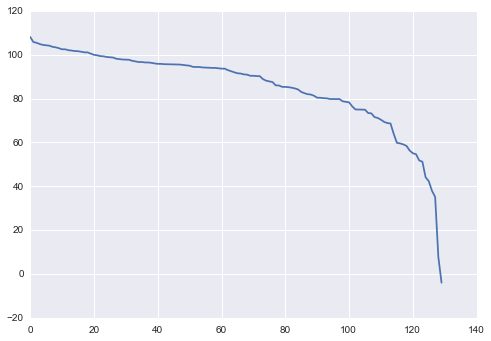

In [17]:
ll = em.logliks()
plt.plot(-np.sort(-ll));
for i in np.argsort(-ll):
    print("%3i: %6.2f = %s" % (i, ll[i],",".join(em.pset[i][0])))

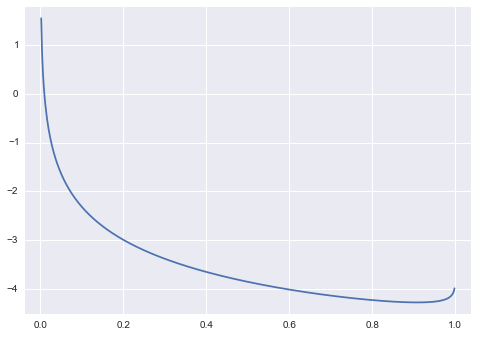

In [24]:
import scipy.stats as sps
x = np.linspace(0,1,501)
plt.margins(0.04)
plt.plot(x,sps.beta.logpdf(x,0.01,0.9));

In [19]:
res = em.getResults()
wei = pd.DataFrame(list(it.chain(res.getMarginalWeights())),
                   columns=["regulator","target","weight"])
# get down to the mean of each regulator and target
weim = wei.groupby(["regulator","target"]).mean()
weim /= weim.sum()

In [20]:
wei.groupby("target").sum()

,weight
target,
Gene2,2.967975
